## 목차
### 1. Library Import
### 2. 학습데이터 생성
### 3. Light-gbm 모델 훈련
### 4. 교차 검증 점수 확인
### 5. 제출 파일 생성

# 1. Library Import

In [ ]:

import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/', nb_path) 
sys.path.insert(0, nb_path)

Mounted at /content/mnt


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import tensorflow as tf
import string
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense,Softmax, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import warnings
warnings.filterwarnings(action='ignore')





# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    #print("x="+x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #print(year,month,day,hour)
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour) #20201130190653

def string2num(x):
    # (,)( )과 같은 불피요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)

PATH='/content/mnt/MyDrive/Colab Notebooks/'
#PATH = '/content/'

# 2. 학습 데이터 생성

## 2.1 train_err

* train_err_data.csv 파일의 errtype column의 value_counts를 카운트하여 학습에 사용.  
* 주어진 기간동안 user_id별로 peroblem가 한 번이라도 발생했는 지를 확인.  

In [ ]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
display(train_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [ ]:
# 데이터 설명을 확인하면
# ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
display(train_err.head())
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [ ]:
#참고) 일별 합산 데이터 생성 코드      
import datetime
#train_err = pd.read_csv(PATH+'train_err_data.csv')
train_err['datetime']=pd.to_datetime(train_err['time'])
#train_err['time']
#train_err['time'][0]
#print(train_err['time'])
train_err['datetime'] = train_err['time'].apply(make_datetime)
print(train_err['datetime'][1])
if(train_err['datetime'][0]<train_err['datetime'][1]+datetime.timedelta(hours=1)):
    print("true")


2020-11-01 03:00:00
true


In [ ]:
errdic={}
errdic[1]=0
errdic[2]=1
errdic[3]=2
errdic[4]=3
errdic[5]=4
errdic[6]=5
errdic[8]=6
errdic[9]=7
errdic[10]=8
errdic[13]=9
errdic[14]=10
errdic[15]=11
errdic[17]=12
errdic[18]=13
errdic[19]=14
errdic[22]=15
errdic[24]=16
errdic[25]=17
errdic[26]=18
errdic[27]=19
errdic[30]=20
errdic[31]=21
errdic[32]=22
errdic[33]=23
errdic[34]=24
errdic[36]=25
errdic[38]=26
errdic[39]=27
errdic[40]=28
errdic[41]=29
errdic[42]=30
print(errdic)
print(errdic[8])
a=29
if (a in errdic):
    print(errdic[a])

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 8: 6, 9: 7, 10: 8, 13: 9, 14: 10, 15: 11, 17: 12, 18: 13, 19: 14, 22: 15, 24: 16, 25: 17, 26: 18, 27: 19, 30: 20, 31: 21, 32: 22, 33: 23, 34: 24, 36: 25, 38: 26, 39: 27, 40: 28, 41: 29, 42: 30}
6


In [ ]:
st='04.33.1149'
la=st.split(".")
print(la)
for i in la:
    if( int(i) ==10):
        print(int(i)*100)
        break
    print(int(i))

def fwwitherr(fwv,errt):
    la=fwv.split(".")
    sum=0
    for i in range(len(la)):
        if i==2:
            return sum*100+errt
        if( int(la[i]) == 10 and i==0):
            return 10000+errt
        sum+= int(la[i])* (100**(1-i))
        
    return sum*100+errt
def fwint(fwv):
    la=fwv.split(".")
    return int(la[0])
print(fwwitherr(st,42))
print(fwint(st))

['04', '33', '1149']
4
33
1149
43342
4


In [ ]:
import itertools
a=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
npr=itertools.permutations(a,3)
ac=list(npr)
#print(len(ac)) 990개 색깔
#plt.plot([1,2,3,4],c=ac[989])


In [ ]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.
import copy
id_error = train_err[['user_id','datetime','fwver','errtype','errcode']].values
error = np.zeros((train_user_number,42)) #15000,42 의 0배열 생성.
#errorreduc=np.zeros((train_user_number,32))
minnum=317
curuser=10000
#errstrli=np.zeros((train_user_number,1),dtype="object")

#errli=np.empty((train_user_number,1),dtype="object")
sum=0
allnum=0
color=0
tempstr=""
#usid,dtime,fw,erty,errco
cnt=0
for person_idx,dtime,fw,err,errco in tqdm(id_error):
    #print(person_idx)
    if (errco=='standby'):
        continue
    '''
    if (curuser==person_idx):
      templi.append(err)
      tempstr+=" "+str(err)
    else:
      errli[curuser-train_user_id_min][0]=np.array(templi)
      
      templi=[]
      templi.append(err)

      tempstrli.append(tempstr)
     # tempstrli=tempstrli[1:]
      strli.append(tempstrli)
      #print(curuser-train_user_id_min)
      errstrli[curuser-train_user_id_min]=copy.deepcopy(tempstrli)
      tempstrli=[]
      curuser=person_idx
      tempstr=""
      tempstr+=" "+str(err)
    '''
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1  그래서 [사람idx,error type] 번째에 +=1 되는건데, errtype이 1~42니까 -1 해서 errtype의 min은 0번부터시작, person도 0번부터 시작
    error[person_idx - train_user_id_min,err - 1] += 1
    
    #error[person_idx-train_user_id_min,42]=fwint(fw)
    #if (err in errdic):
    #    errorreduc[person_idx-train_user_id_min,errdic[err]]+=1
    #    errorreduc[person_idx-train_user_id_min,31]=fwint(fw)
#errli[curuser-train_user_id_min][0]=np.array(templi) #마지막에는 한번 안 더해져서나와.
#tempstrli.append(tempstr)
#tempstrli=tempstrli[1:]
#print("tempstrl",tempstrli)
#strli.append(tempstrli)
#newstrli=np.array(strli)
#errstrli[curuser-train_user_id_min]=copy.deepcopy(tempstrli)
print("shape=",error.shape)
#print("errli[0]=",errli[0])
#print("errli.shape",errli[0].shape)
#print("errli[0][0]",errli[0][0])



        

# 이말인즉슨, 1 row에 err type 0 이 몇회 발생 , 1이 몇회발생 ~~~


100%|██████████| 16554663/16554663 [00:31<00:00, 522889.24it/s]

shape= (15000, 42)


## 2.2 problem

In [ ]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')

problem = np.zeros(15000)
newproblem=np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0   문제가 하나도 없었던 사람은 0이야.
problem[train_prob.user_id.unique()-10000] = 1   
problem.shape
max=0
prob=train_prob[['user_id']].values
for i in prob:
    newproblem[i-10000]+=1
print(np.max(newproblem))

'''
    if(max<problem[i]):
        max=problem[i]
        print(i,max)
'''
        

5.0


'\n    if(max<problem[i]):\n        max=problem[i]\n        print(i,max)\n'

In [ ]:
#problem 개수
cntmy=[0]*15000
train_prob.shape # (5429,2)
timeprob=np.zeros((15000,5,5),dtype="object")
train_prob['datetime'] = train_prob['time'].apply(make_datetime)
id_probl = train_prob[['user_id','datetime']].values
#id_errtime=train_err[['user_id','datetime','fwver','errtype','errcode']].values



In [ ]:
a=0
person,timeid=id_probl[a]
print(person,timeid)
ab=[]
#print(id_errtime[0],id_errtime[500])# 10000 번째, 10001번쨰 두명있네.
curuser=10000
first=0
last=0
cnt=0
idarr=[]
for uid,dtime,fw,errty,errco in tqdm(id_error):
    if (curuser==uid):
        last=cnt
    else:
        li=[]
        li.append(first)
        li.append(last)
        idarr.append(li)
        first=cnt
        curuser=uid
    cnt+=1
li=[]
li.append(first)
li.append(last)
idarr.append(li)




  0%|          | 71016/16554663 [00:00<00:23, 710152.21it/s]

19224 2020-11-02 20:00:00


100%|██████████| 16554663/16554663 [00:21<00:00, 786359.11it/s]


In [ ]:
cnt=0
cntmy=[0]*15000
plotli=[]
sn=0
timeerror=2 #+-12시간
for person_idx, timeid in tqdm(id_probl):
    cntmy[person_idx-10000]+=1
    cnt+=1
    #print(person_idx,timeid)
    tili=[]#timelist
    tyli=[]#typelist
    coli=[]#codelist
    fwli=[]#fwverlist
    haschanged=[]
    first,last =idarr[person_idx-10000]
    for i in range(first,last+1):
        uid,dtime,fw,errty,errco = id_error[i] 
        if( timeid+datetime.timedelta(hours=timeerror*-1) <dtime< timeid+datetime.timedelta(hours=timeerror)):
            tili.append(dtime)
            tyli.append(errty)
            coli.append(errco)
            fwli.append(fw)
    if(len(Counter(fwli).keys())>1):
        haschanged.append(1)
    else:
        haschanged.append(0)
    tim=[]
    tim.append(timeid)
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,0]=tim #같은 사용자가 여러번 problem을 냈을 수 있다. 0번째는 그 problem시간
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,1]=tili#err시간
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,2]=tyli#errtype
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,3]=coli#errcode
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,4]=fwli#firmware
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,4]=haschanged


#print(tim,tili,tyli,coli)
    

100%|██████████| 5429/5429 [01:00<00:00, 89.18it/s] 


In [ ]:
print(timeprob[11,0,4])
print(len(Counter(timeprob[11,0,4]).keys()))
#Counter(plotli2).keys()
print(sn)

['04.22.1750', '04.22.1750', '04.22.1750']
1
42


In [ ]:
li=np.zeros(42)
for i in range(15000):
    for j in range(cntmy[i]):
        errt=timeprob[i][j][2]
        errc=timeprob[i][j][3]
        for idx,val in enumerate(errt):
            li[val-1]+=1
for i,val in enumerate(li):
    print( "<"+str(i)+">",val ,end=" ")
from collections import Counter

<0> 18.0 <1> 10.0 <2> 121.0 <3> 2209.0 <4> 2296.0 <5> 606.0 <6> 628.0 <7> 0.0 <8> 1.0 <9> 438.0 <10> 657.0 <11> 808.0 <12> 179.0 <13> 1184.0 <14> 2985.0 <15> 2726.0 <16> 118.0 <17> 359.0 <18> 35.0 <19> 276.0 <20> 29.0 <21> 3948.0 <22> 4923.0 <23> 40.0 <24> 78.0 <25> 708.0 <26> 3045.0 <27> 3042.0 <28> 0.0 <29> 36.0 <30> 4945.0 <31> 1198.0 <32> 293.0 <33> 1207.0 <34> 275.0 <35> 80.0 <36> 82.0 <37> 44.0 <38> 95.0 <39> 2229.0 <40> 551.0 <41> 2.0 

5000
errortype= 23
no problem 5429
problem O


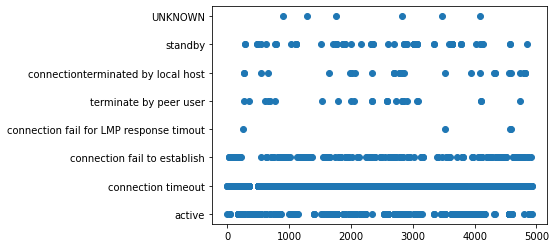

4923 215913


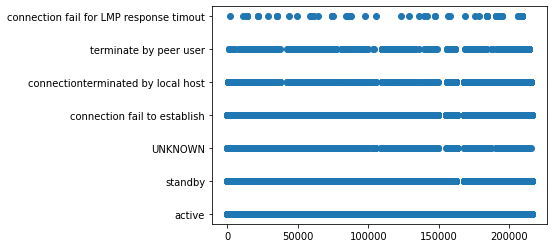

dict_keys(['active', 'standby', 'UNKNOWN', 'connection fail to establish', 'connectionterminated by local host', 'terminate by peer user', 'connection fail for LMP response timout'])
dict_values([899, 3639, 223, 4, 25, 30, 97, 6])
dict_values([107915, 62047, 1815, 41677, 1852, 533, 74])


In [ ]:
plotli2=[] #problem없는

ERRTYP=23
sum=0
for i in range(15000):
    if (cntmy[i]>0):
        sum+=1
        continue
    else:
        first,last =idarr[i]
        for i in range(first,last+1):
            uid,dtime,fw,errty,errco = id_error[i]
            if errty==ERRTYP:
                if(errco.strip() != 'connection timeout'):
                    plotli2.append(errco)
print(sum)
sum=0
plotli=[] #problem있는
for i in range(15000):
    for j in range(cntmy[i]):
        sum+=1
        errt=timeprob[i][j][2]
        errc=timeprob[i][j][3]
        #print(errt)
        for idx,val in enumerate(errt):
            if val==ERRTYP:
                plotli.append(errc[idx])
print("errortype=",ERRTYP)
print("no problem",sum)
for i,val in enumerate(plotli):
    plotli[i]=val.strip()
for i,val in enumerate(plotli2):
    plotli2[i]=val.strip()    
print("problem O")
t1=np.arange(0,len(plotli))
plt.scatter(t1,plotli)
plt.show()
print(len(plotli),len(plotli2))
t2=np.arange(0,len(plotli2))
plt.scatter(t2,plotli2)
plt.show()


#words = ['a', 'b', 'c', 'a']

#Counter(words).keys() # equals to list(set(words))
#Counter(words).values() # counts the elements' frequency
Counter(plotli2).keys() # equals to list(set(words))
Counter(plotli2).values() # counts the elements' frequency
print(Counter(plotli2).keys())
print(Counter(plotli).values())
print(Counter(plotli2).values())

In [ ]:


#words = ['a', 'b', 'c', 'a']

#Counter(words).keys() # equals to list(set(words))
#Counter(words).values() # counts the elements' frequency
Counter(plotli2).keys() # equals to list(set(words))
Counter(plotli2).values() # counts the elements' frequency
print(Counter(plotli2).keys())
print(Counter(plotli2).values())
print( "connection fail to establish" in ['active', 'standby', 'UNKNOWN', 'connection fail to establish', 'connectionterminated by local host', 'terminate by peer user', 'connection fail for LMP response timout'])

dict_keys(['active', 'standby', 'UNKNOWN', 'connection fail to establish', 'connectionterminated by local host', 'terminate by peer user', 'connection fail for LMP response timout'])
dict_values([107915, 62047, 1815, 41677, 1852, 533, 74])
True


In [ ]:
errlistprob=np.zeros((5500,42))
labprob=np.zeros((5500))
cindex=0
for i in range(15000):
    for j in range(cntmy[i]):
        temp=timeprob[i][j]
        #print(temp[2])
        for k in range(len(temp[2])):
            #if (temp[2][k]==23):
                #if(temp[3][k].strip() in ['terminate by peer user','connection fail for LMP response timout','connectionterminated by local host'])
            if temp[2][k]==23:
                if temp[3][k].strip() in ['standby']:
                  continue
            errlistprob[cindex,temp[2][k]-1]+=1
        labprob[cindex]+=1
        cindex+=1        


In [ ]:
print(cindex)
print(len(error))


5429
15000


In [ ]:
totalerror=np.zeros((20430,42))
labelprob=np.zeros((20430))
cindex=0
for i in range(len(error)):
    for j in range(0,42):
        totalerror[cindex,j]=error[i,j]
    labelprob[cindex]=problem[i]
    cindex+=1
print(cindex)
for i in range(5429):
    for j in range(0,42):
        totalerror[cindex,j]=errlistprob[i,j]
    labelprob[cindex]=problem[i]
    cindex+=1
    


15000


#2.42 weightli만들기

In [ ]:
#weight list구하기
weightli=[0.7]*23430
numerr=800
discount=0.3
cnt=0
sum=0
for i,val in enumerate(error):
    cnt=0
    for j in val:
        cnt+=j
    if i>15000:
        weightli[i]+=2
    elif (cnt>numerr):
        sum+=1
        weightli[i]-=discount
    
print(sum)

5724


In [ ]:
'''
errlistprob=np.zeros((5500,42))
cindex=0
for idx,val in enumerate(timeprob):
      if idx == 2:
          break
      else:
          print(val)
for idx,val in enumerate(timeprob):
    if (type(val[0][0])==int):
        continue
    numofp=cntmy[idx]
    for i in range(numofp):
        for j in val[2]:
            print(val)
            errlistprob[cindex,j-1]+=1
        cindex+=1
'''

'\nerrlistprob=np.zeros((5500,42))\ncindex=0\nfor idx,val in enumerate(timeprob):\n      if idx == 2:\n          break\n      else:\n          print(val)\nfor idx,val in enumerate(timeprob):\n    if (type(val[0][0])==int):\n        continue\n    numofp=cntmy[idx]\n    for i in range(numofp):\n        for j in val[2]:\n            print(val)\n            errlistprob[cindex,j-1]+=1\n        cindex+=1\n'

#2.4 quality data가져오기

# 2.5 validation set 만들기


In [ ]:
'''
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val= train_test_split(errstrli,problem, test_size=0.1,shuffle=True,random_state=1004)
print("validation set shape=",x_val.shape,y_val.shape) #1500개의 validation set

print(x_train[15],y_train[15])
'''

'\nfrom sklearn.model_selection import train_test_split\n\nx_train, x_val, y_train, y_val= train_test_split(errstrli,problem, test_size=0.1,shuffle=True,random_state=1004)\nprint("validation set shape=",x_val.shape,y_val.shape) #1500개의 validation set\n\nprint(x_train[15],y_train[15])\n'

#2.6 Embedding layer만들기
The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings)
https://www.tensorflow.org/tutorials/text/word_embeddings?hl=en

즉, 각각의 error type을 dense vector로 바꿔주는 것이 
embedding layer이며, dimentionality (width) 를 조정하면서
내 문제에 잘 맞는지 확인할 수 있다.
Dense layer에 node를 몇개 둘 것인지 계속 바꿔나가는 것 과 같이.
``` python
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)
```
### 방안
1. 단순하게 생각하면, 우린 42개의 error type이 있다고 볼 수 있다. 고로 42개의 error type 각각을 dense vector로 바꿔주면 되지 않을까?
고로, embedding_layer을 다음과같이만들어보자.
2. 아니면 42개의 error type이 있는건 맞지만, 되게 다양한 state에서의 error type이존재하기도 한다. 즉 1번 에러 뒤에오는 2번이라던지?
근데 경우의 수가 너무 많아지고 본래도 비슷할 것 같다
왜냐하면 word도 앞에나올수도 있고 뒤에 나올 수도 있기 때문

지금 sequence dimension이라는 것은
5 이런거. 우리가 5차원으로 뒀지.
1000개의 sequence가 있어 위 예제에는.

### 2.7 layer에 넣는작업

layer에 넣으려면 errli[0]은 317개의 err type 즉, 317개의 5차원 seqeuence가 존재할테고
errli[1]은 뭐 몇개 이런식으로 존재할텐데
그 개수를 통일시키기 위해서
global Average Pooling 1D layer을 두면, 317개의 5차원 sequence들의 평균을 이용해서 둘 수 도 있고,
RNN 을 이용할 수도 있어.
일단 global Average Pooling 1D

#2.5 word embedding



# 3. Light-gbm 모델 훈련

In [ ]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y
#totalerror labelprob
#train_x = error
#train_y = problem
train_x = totalerror
train_y = labelprob
origtrain_x=error
origtrain_y=problem
weightnpli=np.array(weightli)
#del error, problem
print(train_x.shape)
print(train_y.shape)
print(weightnpli.shape)
print(origtrain_x.shape,origtrain_y.shape)

(20430, 42)
(20430,)
(23430,)
(15000, 42) (15000,)


In [ ]:
train_x[0][31]


0.0

In [ ]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------

paramnw={'num_leaves':100,
       'min_data_in_leaf':30,
       'objective':'binary',
       'max_depth':6 ,
       'learning_rate':0.005 ,#'learning_rate':0.02 ,
       'boosting':"gbdt",
       "feature_fraction":0.7522,
       "bagging_freq":1,
       "bagging_fraction":0.7083,
       "bagging_seed":11,
       "metric":"rmse",
       "random_state":133
       }
params = {'learning_rate': 0.01,
              'max_depth': 16,
              'boosting': 'gbdt',
              'objective': 'binary',
              'metric': 'auc',
               #'is_training_metric': True,\n",
             'num_leaves': 144,
              'feature_fraction': 0.9,
              'bagging_fraction': 0.7,
              'bagging_freq': 5,
              'seed':2020}

models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
'''
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(origtrain_x):
    X=origtrain_x[train_idx]
    y=origtrain_y[train_idx]
    valid_x=origtrain_x[val_idx]
    valid_y=origtrain_y[val_idx]   
    d_train=lgb.Dataset(X,y)
    d_val = lgb.Dataset(valid_x,valid_y)
    model2 = lgb.train(
                        paramnw,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 200
                       )
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)
    print('==========================================================')
'''
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):
    X=train_x[train_idx]
    y=train_y[train_idx]
    weightnplis=weightnpli[train_idx]
    valid_x=train_x[val_idx]
    valid_y=train_y[val_idx]
    d_train=lgb.Dataset(X,y, weight=weightnplis)
    d_val = lgb.Dataset(valid_x,valid_y)

    #run traning
    model = lgb.train(
                        paramnw,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 200
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

Training until validation scores don't improve for 200 rounds.
[20]	valid_0's rmse: 0.460979	valid_0's pr_auc: 0.601308
[40]	valid_0's rmse: 0.455142	valid_0's pr_auc: 0.600362
[60]	valid_0's rmse: 0.4503	valid_0's pr_auc: 0.600124
[80]	valid_0's rmse: 0.446057	valid_0's pr_auc: 0.602366
[100]	valid_0's rmse: 0.442603	valid_0's pr_auc: 0.602355
[120]	valid_0's rmse: 0.43959	valid_0's pr_auc: 0.602762
[140]	valid_0's rmse: 0.436889	valid_0's pr_auc: 0.605694
[160]	valid_0's rmse: 0.43471	valid_0's pr_auc: 0.605114
[180]	valid_0's rmse: 0.432798	valid_0's pr_auc: 0.606468
[200]	valid_0's rmse: 0.431113	valid_0's pr_auc: 0.607587
[220]	valid_0's rmse: 0.429754	valid_0's pr_auc: 0.607202
[240]	valid_0's rmse: 0.428634	valid_0's pr_auc: 0.606123
[260]	valid_0's rmse: 0.427643	valid_0's pr_auc: 0.607691
[280]	valid_0's rmse: 0.426766	valid_0's pr_auc: 0.608595
[300]	valid_0's rmse: 0.425946	valid_0's pr_auc: 0.609121
[320]	valid_0's rmse: 0.4253	valid_0's pr_auc: 0.610091
[340]	valid_0's rms

# 4. 교차검증 점수 확인

In [ ]:
print(np.mean(auc_scores)) #0.7459298202316195 0.8066887653152083 
# 0.8072759477430488 0.746440183016864 0.7471924683182276 0.7475194696987806

0.7453882457824647


# 5. 제출 파일 생성

In [ ]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
display(test_err.head())
print(test_err.fwver.unique())

,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2
2,30000,20201101030228,model_1,04.16.3553,15,1
3,30000,20201101030256,model_1,04.16.3553,22,1
4,30000,20201101030300,model_1,04.16.3553,11,1


['04.16.3553' '04.16.3571' '04.33.1261' '05.15.2138' '04.22.1750'
 '04.22.1778' '04.33.1149' '03.11.1167' '04.33.1185' '04.22.1684'
 '05.15.2120' '04.82.1684' '04.82.1778' '10' '05.66.3237' '04.73.2569'
 '04.73.2571' '04.73.2237' '04.73.2577' '04.82.1730' '04.22.1478' '8.5.3'
 '04.22.1666' '04.22.1656' '03.11.1149' '04.33.1171' '05.66.3571'
 '04.16.3439' '05.15.2092' '03.11.1141' '04.22.1608' '05.15.3104'
 '04.33.1125' '04.22.1448' '05.15.2114' '10.22.1770' '10.22.1780'
 '04.16.3569' '04.22.1772' '04.22.1170']


In [ ]:
# 데이터 설명을 확인하면
# test 데이터는 ueser_id가 30000부터 44998까지 총 14999개가 존재.
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [ ]:
id_error = test_err[['user_id','time','fwver','errtype','errcode']].values
#fulltest_x=np.zeros((test_user_number,42))
test_x = np.zeros((test_user_number,42))
for  person_idx,dtime,fw,err,errco in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    if errco in ['standby']:
        continue
    test_x[person_idx - test_user_id_min,err - 1] += 1
    #test_x[person_idx-test_user_id_min,err-1]+=1
    #fulltest_x[person_idx-test_user_id_min,42]=fwint(fw)
    #if (err in errdic):
     #   test_x[person_idx - test_user_id_min, errdic[err]]+=1
     #   test_x[person_idx-test_user_id_min,31]=fwint(fw)
#fulltest_x=test_x.reshape(fulltest_x.shape[0],-1)
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████| 16532648/16532648 [00:32<00:00, 511266.80it/s]

(14999, 42)


In [ ]:
# 예측
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    #pred_y = model.predict(fulltest_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)


In [ ]:
pred_ensemble
#

array([[0.90540304],
       [0.20291774],
       [0.28798703],
       ...,
       [0.56585422],
       [0.85852292],
       [0.39145087]])

In [ ]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

In [ ]:
sample_submssion['problem'] = pred_ensemble.reshape(-1)

In [ ]:
sample_submssion.to_csv("byeon_highest8.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.905403
1,30001,0.202918
2,30002,0.287987
3,30003,0.710779
4,30004,0.669103
...,...,...
14994,44994,0.300012
14995,44995,0.297071
14996,44996,0.565854
14997,44997,0.858523


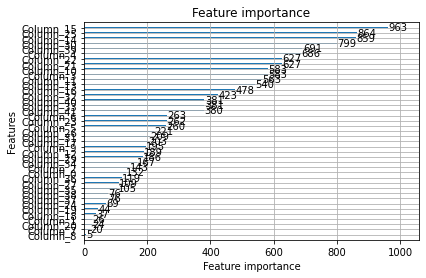

In [ ]:
lgb.plot_importance(model)
plt.show()
feature_importance=pd.DataFrame([model.feature_name(),model.feature_importance()]).T
feature_importance.columns=["features","varimp"]
feature_importance=feature_importance.sort_values(["varimp"],ascending=False)
feature_importance.head()
feature_importance.to_csv("importance.csv",index=False)